<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Técnicas-de-aprendizaje-supervisado" data-toc-modified-id="Técnicas-de-aprendizaje-supervisado-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Técnicas de aprendizaje supervisado</a></span><ul class="toc-item"><li><span><a href="#Practica-de-Intercomparación-aplicada-a-datos-meteorológicos" data-toc-modified-id="Practica-de-Intercomparación-aplicada-a-datos-meteorológicos-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Practica de Intercomparación aplicada a datos meteorológicos</a></span><ul class="toc-item"><li><span><a href="#Santander-Meteorology-Group" data-toc-modified-id="Santander-Meteorology-Group-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Santander Meteorology Group</a></span></li></ul></li></ul></li><li><span><a href="#Conjunto-de-datos-meteo" data-toc-modified-id="Conjunto-de-datos-meteo-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Conjunto de datos meteo</a></span></li><li><span><a href="#Árboles-de-clasificación-y-regresión-(2.5-puntos)" data-toc-modified-id="Árboles-de-clasificación-y-regresión-(2.5-puntos)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Árboles de clasificación y regresión (2.5 puntos)</a></span></li><li><span><a href="#Random-forests-(2.5-puntos)" data-toc-modified-id="Random-forests-(2.5-puntos)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Random forests (2.5 puntos)</a></span></li><li><span><a href="#Modelos-lineales-generalizados-(GLMs)-(1.5-puntos)" data-toc-modified-id="Modelos-lineales-generalizados-(GLMs)-(1.5-puntos)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Modelos lineales generalizados (GLMs) (1.5 puntos)</a></span></li><li><span><a href="#k-nearest-neighbors-(k-NN)-(1.5-puntos)" data-toc-modified-id="k-nearest-neighbors-(k-NN)-(1.5-puntos)-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>k nearest neighbors (k-NN) (1.5 puntos)</a></span></li><li><span><a href="#Conclusiones-generales-(2-puntos)" data-toc-modified-id="Conclusiones-generales-(2-puntos)-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Conclusiones generales (2 puntos)</a></span></li></ul></div>

# Minería de Datos (Master en Data Science, UIMP-UC)

## Técnicas de aprendizaje supervisado

### Practica de Intercomparación aplicada a datos meteorológicos

#### Santander Meteorology Group

En esta práctica haremos una intercomparación de varias de las técnicas de aprendizaje supervisado vistas a lo largo de la asignatura (CART, k-NN, GLMs y Random Forests). Por tanto, pretende ser un repaso general de cara al examen en el que el objetivo es tratar de entender las ventajas y limitaciones de las distintas técnicas para un caso de aplicación particular; la predicción de precipitación. La entrega consistirá en un notebook (Jupyter o R-Markdown), junto con el archivo html que éste genera. Ambos ficheros se entregarán a través del Moodle de la asignatura en la tarea correspondiente.

## Conjunto de datos meteo

Comenzaremos cargando el dataset meteo, que ya ha sido utilizado en sesiones anteriores. Como ya sabéis, la variable objetivo en este dataset es la precipitation diaria en Lisboa durante el período 1979-2008, y para modelizar ésta se dispone de un conjunto de 8 variables meteorológicas predictoras que describen la circulación de larga escala definidas sobre un dominio geográfico que incluye 40 puntos sobre la Península Ibérica. (en total 8×40=320 variables explicativas). Las variables predictoras son:

* altura geopotencial en 500 hPa (Z500)
* temperatura del aire en 850 hPa, 700 hPa, 500 hPa (ta850, ta700 y ta500), y en superficie (tas)
* humedad específica del aire en 850 hPa y 500 hPa (hus850, hus500)
* presión a nivel del mar (psl)

Para agilizar los tiempos de cómputo, reduciremos la dimensionalidad del problema. Como ya se ha visto en sesiones anteriores, una alternativa para tal fin es el uso de PCs. Sin embargo, para no limitar la interpretabilidad de los resultados obtenidos con árboles, utilizaremos otra aproximación aquí. En concreto, optaremos por un análisis de correlaciones, en el que se calcula la correlación de Spearman entre nuestra variable objetivo y todas las variables predictoras disponibles. La asunción de partida es que cuanto más fuerte sea esta correlación, mayor es el vínculo físico entre predictando y predictor, y por tanto, más útil es la información que nos aporta ese predictor. Por tanto, este análisis nos permite descartar predictores poco relevantes. Siguiendo esta idea, calcularemos la correlación existente entre nuestro predictando y los 320 predictores, y eliminaremos aquellos con correlaciones entre -0.4 y 0.4. ¿Cuánto se ha reducido la dimensionalidad del problema?

In [57]:
library(tree)
library(caret)

In [2]:
load("meteo.RData")
ls()
str(x)
str(y)

[1] "x" "y"

 num [1:10958, 1:320] 57043 56963 56523 54628 53584 ...
 num [1:10958, 1] 10.9 0.6 13 0 0 1.2 1.1 0 0 0.7 ...


In [3]:
# Spearman correlations
correlations <- apply(x, 2, function(col) cor(y, col, method = "spearman"))
head(correlations)

[1] -0.4240867 -0.4798011 -0.5266560 -0.5580364 -0.5683502 -0.4068752

In [4]:
# Filter predictors with correlation < -0.4 or > 0.4
selected_predictors <- x[, correlations < -0.4 | correlations > 0.4]
dim(selected_predictors)

[1] 10958    37

In [5]:
original_count <- ncol(x)
filtered_count <- ncol(selected_predictors)
reduction <- (original_count - filtered_count) / original_count * 100

cat("Original number of predictors:", original_count, "\n")
cat("Number of predictors after filtering:", filtered_count, "\n")
cat("Dimensionality reduction:", round(reduction, 2), "%\n")

Original number of predictors: 320 
Number of predictors after filtering: 37 
Dimensionality reduction: 88.44 %


Para simplificar aún más los cálculos, nos limitaremos a los primeros 5000 días del dataset. Como siempre, consideraremos una partición de la muestra en dos subconjuntos independientes, train y test, escogidos aleatoriamente (75% para entrenar y 25% para validar).

## Árboles de clasificación y regresión (2.5 puntos)

Como ya hemos visto en sesiones anteriores, tendremos que crear dos modelos independientes, uno para la clasificación del evento binario lluvia/no lluvia y otro para el evento continuo cantidad de lluvia. Nos centramos en primer lugar en la clasificación lluvia/no lluvia. Para ello, tenemos que crear la variable binaria ocurrencia de precipitación (considera un umbral de 1 mm) y construir el dataframe asociado al problema.

A continuación construiremos el árbol completo (usa la función tree). ¿Cuántos nodos terminales obtienes? ¿Qué variables predictoras dan lugar a las primeras subdivisiones del árbol?

# <font color="pink"> Classification Rain/No Rain, full tree

In [13]:
# Limit dataset to the first 5000 days
x_subset <- x[1:5000, ]
y_subset <- y[1:5000]

# Create a binary variable: 1 if rain >= 1 mm, 0 otherwise
rain_binary <- ifelse(y_subset >= 1, 1, 0)

set.seed(123)

train_indices <- sample(1:nrow(x_subset), size = 0.75 * nrow(x_subset))

# Split the data into train and test
x_train <- x_subset[train_indices, ]
x_test <- x_subset[-train_indices, ]
y_train <- rain_binary[train_indices]
y_test <- rain_binary[-train_indices]

# Combine predictors and binary target into a dataframe
train_data <- data.frame(rain = factor(y_train), x_train)
test_data <- data.frame(rain = factor(y_test), x_test)


Classification tree:
tree(formula = rain ~ ., data = train_data)
Variables actually used in tree construction:
[1] "X285" "X284" "X173" "X4"   "X202" "X8"   "X247"
Number of terminal nodes:  8 
Residual mean deviance:  0.596 = 2230 / 3742 
Misclassification error rate: 0.1269 = 476 / 3750 

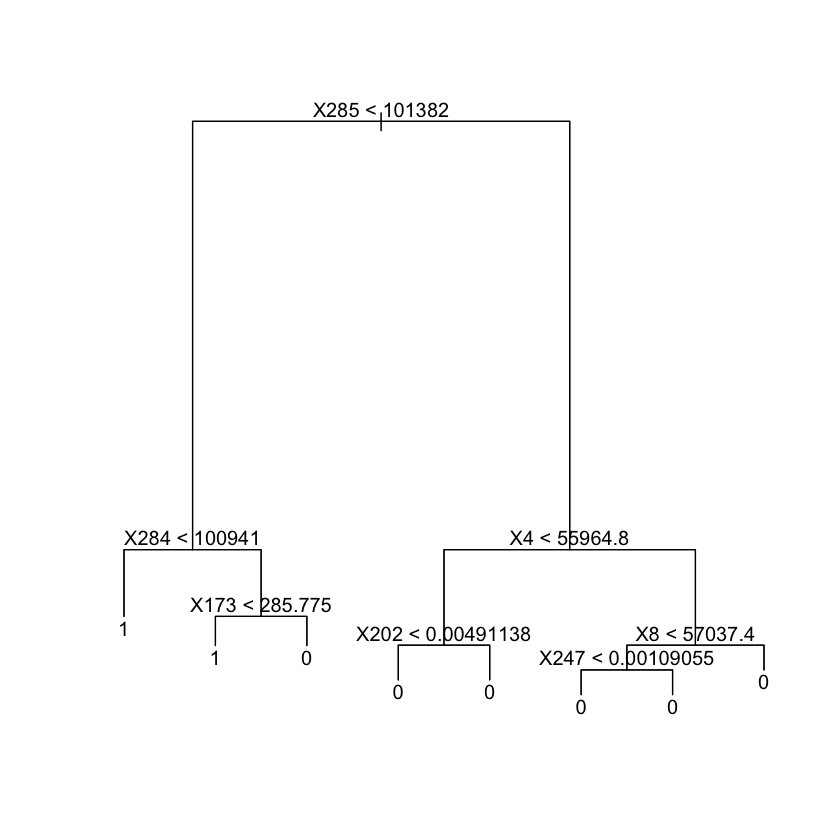

In [32]:
# Build the classification tree
rain_tree <- tree(rain ~ ., data = train_data)

# Summary of the tree
summary(rain_tree)

# Plot the tree
par(bg = "white")
plot(rain_tree)
text(rain_tree, pretty = 0)

The classification tree has 8 terminal nodes. The first variable used for the split is X285, followed by variables such as X284, X173, X4, X202, X8, and X247 in subsequent splits.

# <font color="pink"> Classification

Para simplificar este árbol tan complejo tendremos que podarlo adecuadamente. Utiliza una cross-validación con un 10-fold para encontrar el número de nodos terminales del árbol óptimo. ¿Cuál es este número? ¿Qué predictores aparecen como los más importantes?

$size
[1] 8 4 3 2 1

$dev
[1] 528 528 556 619 705

$k
[1] -Inf    0   48   85  148

$method
[1] "misclass"

attr(,"class")
[1] "prune"         "tree.sequence"


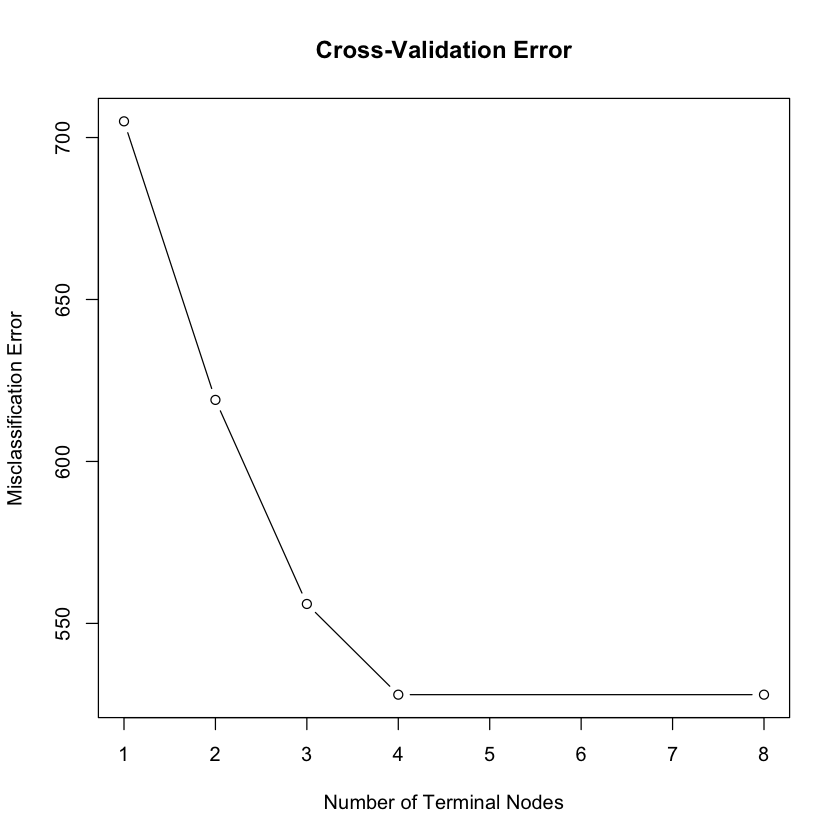

In [31]:
# Perform cross-validation on the tree
set.seed(123)

cv_result <- cv.tree(rain_tree, FUN = prune.misclass, K = 10)

print(cv_result)
par(bg = "white")
plot(cv_result$size, cv_result$dev, type = "b",
     xlab = "Number of Terminal Nodes",
     ylab = "Misclassification Error",
     main = "Cross-Validation Error")

The tree with 4 terminal nodes corresponds to the lowest misclassification error observed during cross-validation. Choosing this tree balances model complexity and performance, avoiding overfitting with larger trees.


Classification tree:
snip.tree(tree = rain_tree, nodes = 3L)
Variables actually used in tree construction:
[1] "X285" "X284" "X173"
Number of terminal nodes:  4 
Residual mean deviance:  0.7005 = 2624 / 3746 
Misclassification error rate: 0.1269 = 476 / 3750 

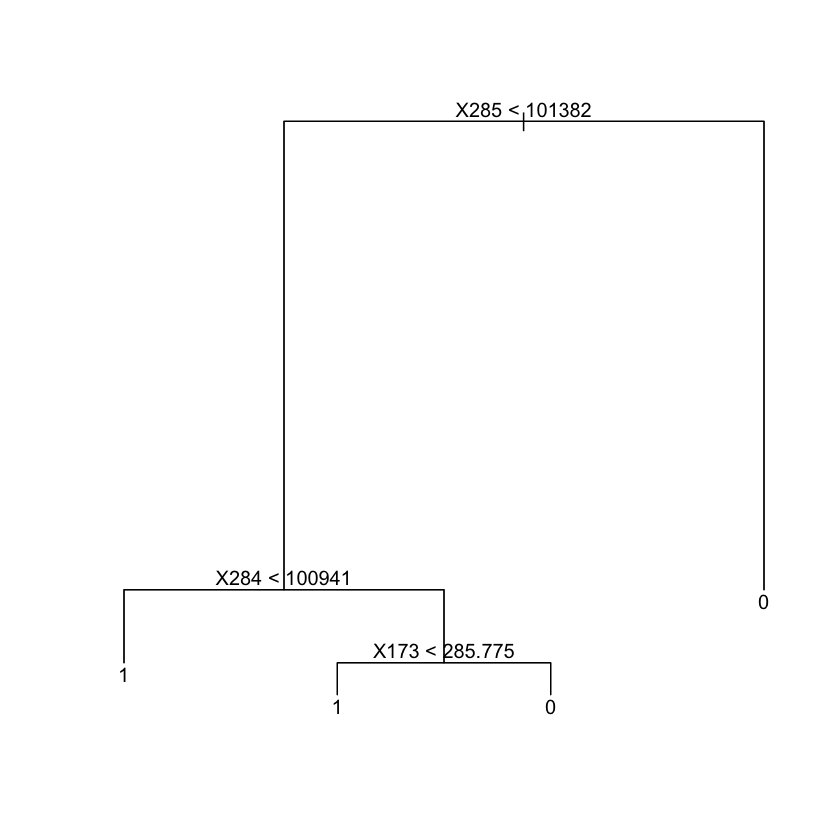

In [34]:
# Prune the tree to have 4 terminal nodes
pruned_tree <- prune.misclass(rain_tree, best = 4)

# Plot the pruned tre
par(bg = "white")
plot(pruned_tree)
text(pruned_tree, pretty = 0)
summary(pruned_tree)

# <font color="pink"> Regression

Utiliza este árbol óptimo para predecir en el test. Guarda las predicciones.

Una vez obtenidas las predicciones de ocurrencia pasaremos a estimar la cantidad de precipitación. Primero creamos el dataset correspondiente.

A continuación construiremos dos árboles, uno entrenado sobre todo el conjunto de train y otro entrenado sólo sobre los días de lluvia (en el train). Empezamos por el primero de estos árboles. Construye el árbol completo ¿Cuántos nodos terminales obtienes? ¿Qué variables predictoras dan lugar a las primeras subdivisiones del árbol? ¿Son las mismas que para el caso de la ocurrencia?

In [54]:
# Evaluate the tree on the test set
predictions_occurrence <- predict(pruned_tree, newdata = test_data, type = "class")

### <font color="pink"> Full tree, all data

In [24]:
# Create a regression dataset
regression_data <- data.frame(rain_amount = y_subset, x_subset)

# Split the data into train and test sets
train_regression <- regression_data[train_indices, ]
test_regression <- regression_data[-train_indices, ]


Regression tree:
tree(formula = rain_amount ~ ., data = train_regression)
Variables actually used in tree construction:
 [1] "X284" "X242" "X298" "X283" "X291" "X302" "X95"  "X140" "X318" "X262"
[11] "X4"   "X202" "X271" "X317"
Number of terminal nodes:  17 
Residual mean deviance:  17.1 = 63830 / 3733 
Distribution of residuals:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-37.7800  -0.9111  -0.3221   0.0000  -0.3221  57.2200 

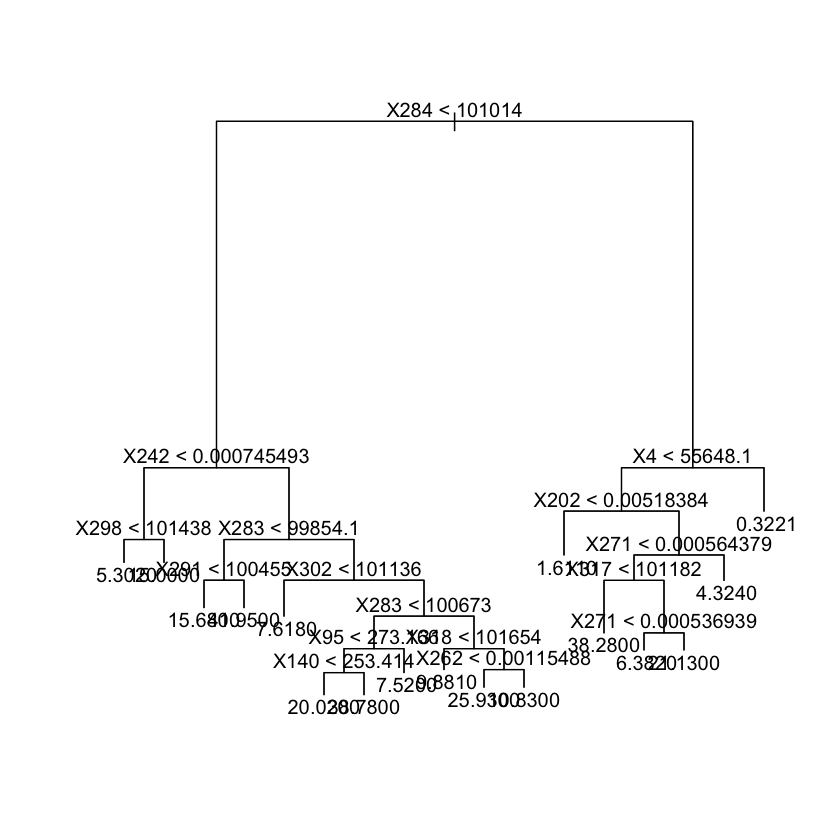

In [35]:
# Build the regression tree on the full training set
tree_full <- tree(rain_amount ~ ., data = train_regression)

# Summary of the tree
summary(tree_full)

# Plot the tree
par(bg = "white")
plot(tree_full)
text(tree_full, pretty = 0)

### <font color="pink"> Full tree, rain data


Regression tree:
tree(formula = rain_amount ~ ., data = rainy_days)
Variables actually used in tree construction:
 [1] "X202" "X274" "X177" "X283" "X293" "X234" "X242" "X302" "X289" "X190"
[11] "X280" "X246" "X317" "X282" "X123" "X284"
Number of terminal nodes:  22 
Residual mean deviance:  49.47 = 36360 / 735 
Distribution of residuals:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-27.400  -4.188  -1.888   0.000   2.825  56.600 

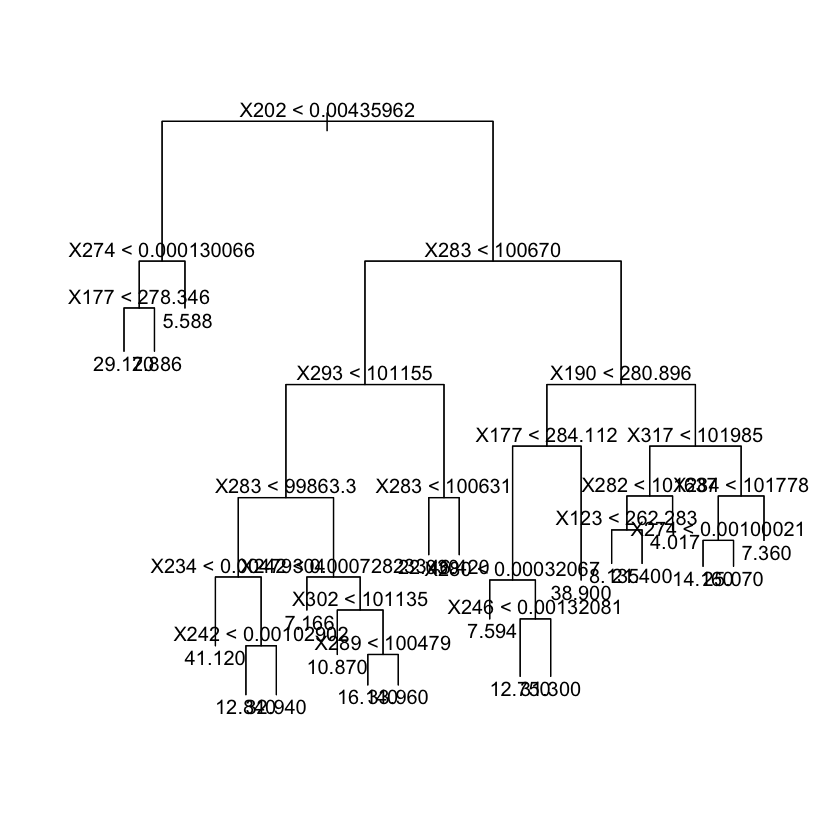

In [36]:
# Subset the training data to include only rainy days
rainy_days <- train_regression[train_regression$rain_amount >= 1, ]

# Build the regression tree for rainy days only
tree_rainy <- tree(rain_amount ~ ., data = rainy_days)

# Summary of the tree
summary(tree_rainy)

# Plot the tree
par(bg = "white")
plot(tree_rainy)
text(tree_rainy, pretty = 0)

All data tree:
- 17 terminal nodes
- main predictors: X284, X242, X4

Rain data only:
- 22 terminal nodes
- main predictors X202, X274, X283

The predictors differ because the models address distinct problems. The all-data tree incorporates all days, including both rainy and non-rainy, and aims to minimize error across the entire dataset. Meanwhile, the rain-data tree focuses only on rainy days, prioritizing predictors that explain variation in rainfall amounts rather than differentiating between rain/no rain. This specialization leads to different predictors being prioritized.


Al igual que hicimos para el caso de la ocurrencia, tendremos que podar este árbol tan complejo. Utiliza una cross-validación con un 10-fold para encontrar el número de nodos terminales del árbol óptimo. ¿Cuál es este número? ¿Qué predictores aparecen como los más importantes?

Utiliza el árbol óptimo que acabas de encontrar para predecir en el test, y conserva la predicción obtenida.

Repite el mismo proceso para el segundo árbol de regresión (el que sólo se entrena sobre los días de lluvia en el train).

Obtén las dos series predichas completas para el test (la secuencia lluvia/no lluvia será la misma en las dos) y valida tus resultados en función de las siguiente métricas:

Para la parte binaria lluvia/no lluvia: Accuracy.
Para la serie completa: RMSE, correlación de Spearman y ratio de varianzas.
Pregunta: ¿Cuál de los dos árboles da mejores resultados? ¿Por qué?

### <font color="pink"> Pruned tree, all data

$size
 [1] 17 16 15 14 13 12 11 10  9  8  6  5  3  2  1

$dev
 [1] 117262.3 114891.4 114505.6 113060.3 112436.0 111648.6 110797.8 109123.8
 [9] 108239.1 108310.4 104897.9 103658.2 104729.6 103396.1 127635.0

$k
 [1]      -Inf  1290.577  1329.807  1581.451  1666.678  1723.444  1810.263
 [8]  2069.813  2455.399  2714.329  2942.873  3073.504  3294.959  5424.465
[15] 26167.313

$method
[1] "deviance"

attr(,"class")
[1] "prune"         "tree.sequence"


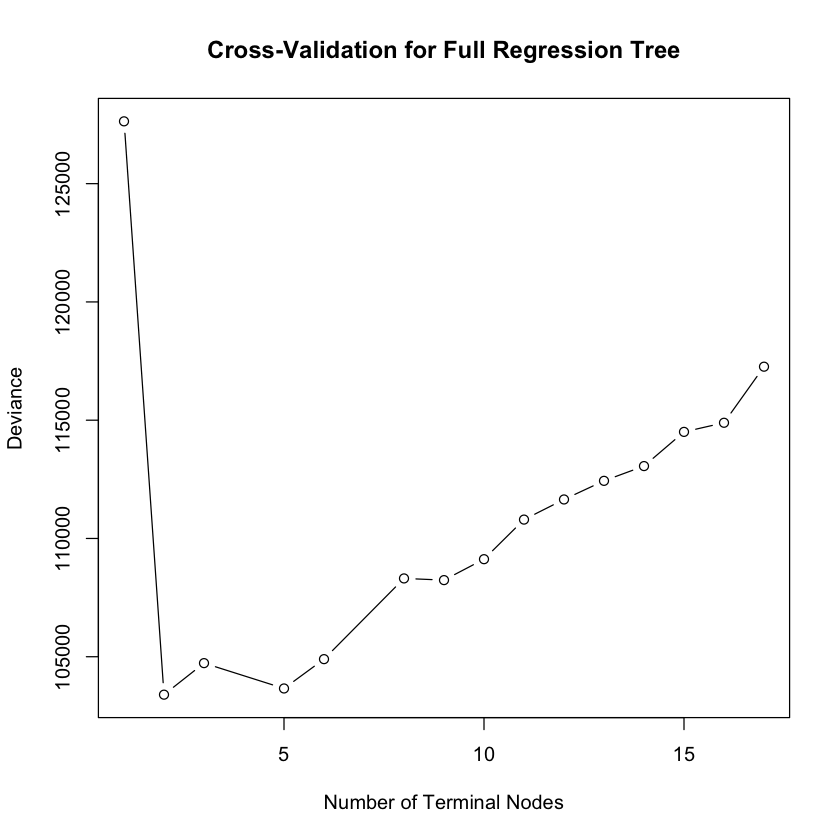

In [52]:
# Perform cross-validation on the full regression tree
set.seed(123)
cv_full <- cv.tree(tree_full, K = 10)

# Print cross-validation results
print(cv_full)

# Plot the cross-validation error as a function of tree size
par(bg = "white")
plot(cv_full$size, cv_full$dev, type = "b",
     xlab = "Number of Terminal Nodes",
     ylab = "Deviance",
     main = "Cross-Validation for Full Regression Tree")

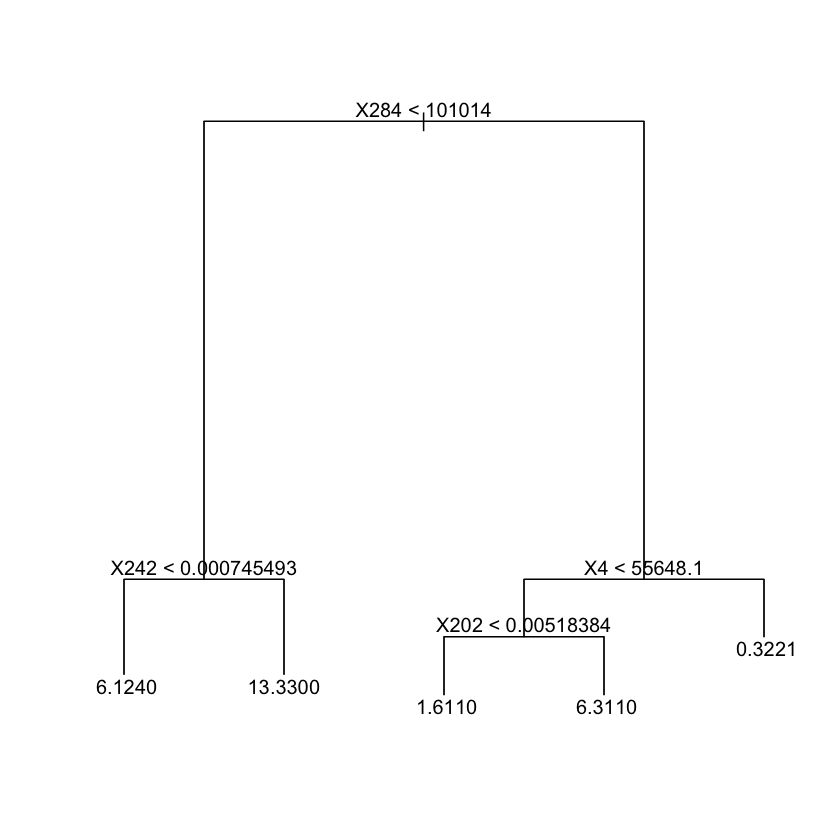

In [41]:
# Prune the full regression tree
pruned_full <- prune.tree(tree_full, best = 5)

# Plot the pruned tree
par(bg = "white")
plot(pruned_full)
text(pruned_full, pretty = 0)

### <font color="pink"> Pruned tree, rain data

$size
 [1] 22 21 20 19 18 16 15 14 13 11 10  9  8  7  6  4  3  2  1

$dev
 [1] 97563.41 97107.83 95492.60 94611.82 94481.23 93348.81 93972.57 93785.39
 [9] 92454.98 92388.09 91998.25 91998.25 89227.65 83926.29 83179.44 75294.25
[17] 76728.78 75574.09 78069.70

$k
 [1]      -Inf  787.7822  925.8975 1018.7869 1032.4274 1178.7818 1315.1101
 [8] 1351.0985 1424.3756 1465.1262 1488.0348 1516.1608 1735.2469 2091.8505
[15] 2413.3878 2972.1218 3438.8214 3753.4781 4251.7013

$method
[1] "deviance"

attr(,"class")
[1] "prune"         "tree.sequence"


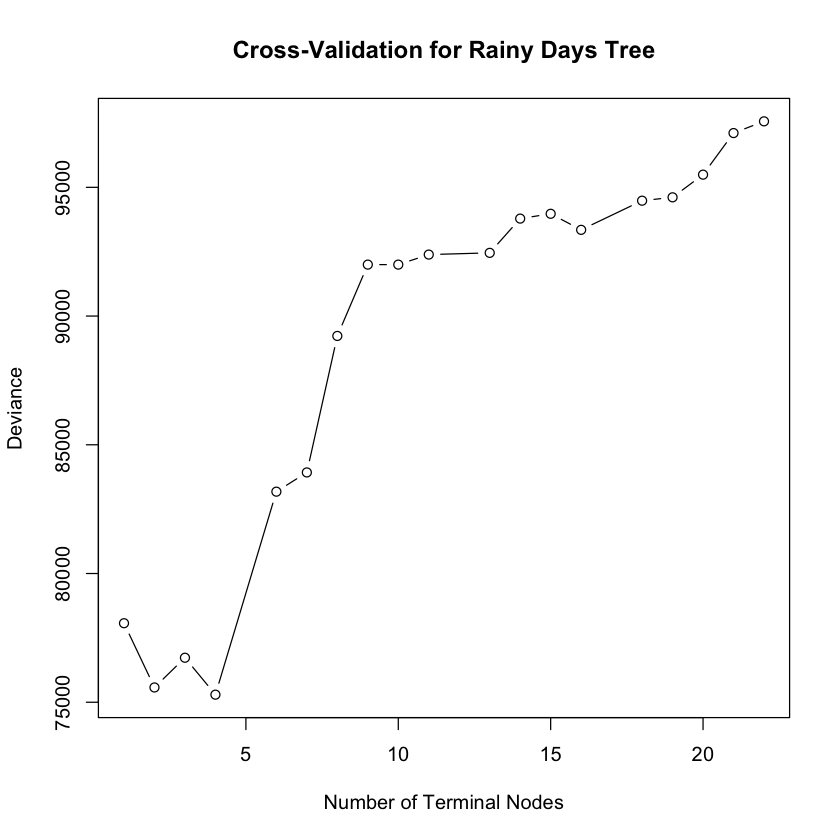

In [43]:
# Perform cross-validation on the rainy days regression tree
cv_rainy <- cv.tree(tree_rainy, K = 10)

# Print cross-validation results
print(cv_rainy)

# Plot the cross-validation error
par(bg = "white")
plot(cv_rainy$size, cv_rainy$dev, type = "b",
     xlab = "Number of Terminal Nodes",
     ylab = "Deviance",
     main = "Cross-Validation for Rainy Days Tree")

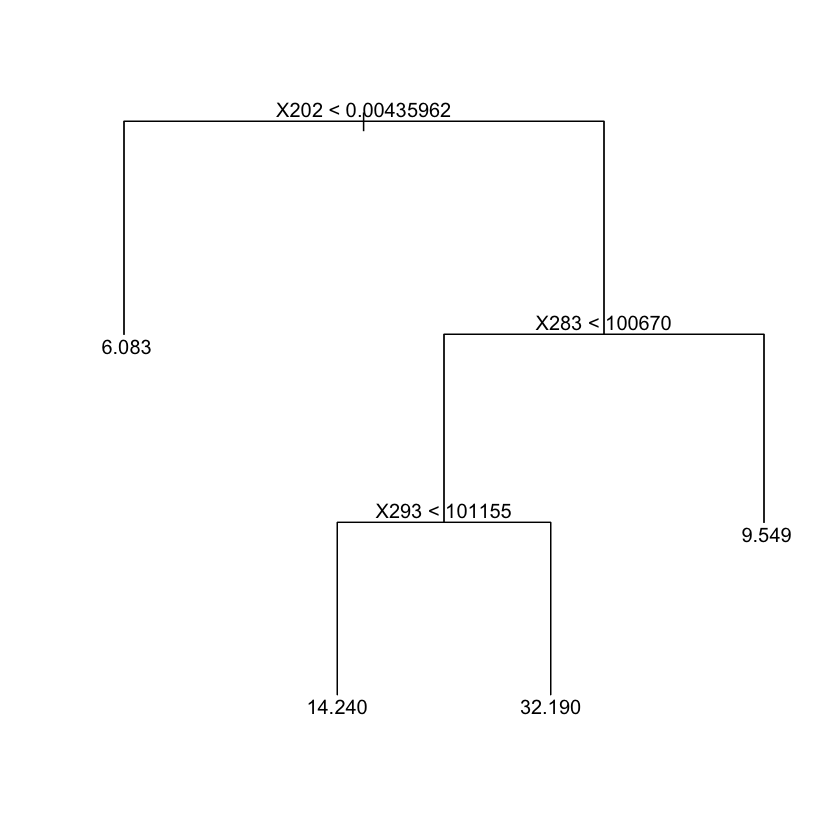

In [44]:
# Prune the rainy days regression tree
pruned_rainy <- prune.tree(tree_rainy, best = 4)

# Plot the pruned tree
par(bg = "white")
plot(pruned_rainy)
text(pruned_rainy, pretty = 0)

All data tree:
- 5 is the optimal number. Although the deviance is slightly lower at 3 terminal nodes, the model shows instability as the deviance increases at 4 nodes and then decreases again at 5. Choosing 5 terminal nodes ensures a more stable and robust model, as the deviance consistently increases beyond this point.
- Main predictors: X284, X242, X4

Rain data only:
- 4 is the optimal number, for the same reason metione above.
- Main predictors X202, X283

# <font color="pink"> Predictions

In [67]:
# Prediction with Full Tree
predictions_full <- predict(pruned_full, newdata = test_regression)

In [53]:
# Prediction with Rainy Days Tree
# Subset the test data for rainy days (rain_amount >= 1)
rainy_test <- test_regression[test_regression$rain_amount >= 1, ]
# Predict precipitation amounts on the rainy days in the test set
predictions_rainy <- predict(pruned_rainy, newdata = rainy_test)
# Combine predictions with 0 for non-rainy days to match the full test set
predictions_combined <- ifelse(test_regression$rain_amount >= 1, predictions_rainy, 0)

In [147]:
# Complete series
predictions_occurrence <- as.numeric(as.character(predictions_occurrence))

final_predictions_full <- predictions_occurrence * predictions_full
final_predictions_combined <- predictions_occurrence * predictions_combined

# <font color="pink"> Results validation

In [63]:
test_binary <- as.numeric(as.character(test_data$rain))

# Create the confusion matrix and extract accuracy
conf_matrix_binary <- confusionMatrix(factor(predictions_occurrence), factor(test_binary))

accuracy <- conf_matrix_binary$overall["Accuracy"]
print(conf_matrix_binary)

Accuracy: 0.8448 


In [152]:
# RMSE
rmse_full <- sqrt(mean((test_regression$rain_amount - final_predictions_full)^2))
rmse_combined <- sqrt(mean((test_regression$rain_amount - final_predictions_combined)^2))

# Spearman Correlation
spearman_full <- cor(test_regression$rain_amount, final_predictions_full, method = "spearman")
spearman_combined <- cor(test_regression$rain_amount, final_predictions_combined, method = "spearman")

# Variance Ratio
variance_ratio_full <- var(final_predictions_full) / var(test_regression$rain_amount)
variance_ratio_combined <- var(final_predictions_combined) / var(test_regression$rain_amount)


In [160]:
cat("Individual Tree - Binary Model:\n")
cat("Accuracy:", accuracy, "\n\n")

cat("Individual Tree - Full Model:\n")
cat("RMSE:", rmse_full, "\n")
cat("Spearman Correlation:", spearman_full, "\n")
cat("Variance Ratio:", variance_ratio_full, "\n\n")

cat("Individual Tree - Rainy Days Model:\n")
cat("RMSE:", rmse_combined, "\n")
cat("Spearman Correlation:", spearman_combined, "\n")
cat("Variance Ratio:", variance_ratio_combined, "\n")

Individual Tree - Binary Model:
Accuracy: 0.8448 

Individual Tree - Full Model:
RMSE: 4.520071 
Spearman Correlation: 0.5419798 
Variance Ratio: 0.4079148 

Individual Tree - Rainy Days Model:
RMSE: 4.503599 
Spearman Correlation: 0.6013398 
Variance Ratio: 0.3476339 


| Metric                | Full Tree  | Rainy Days Tree | Binary Tree |
|-----------------------|------------|-----------------| ----------- |
| RMSE                 | 4.520      |   4.504         |             |
| Spearman Correlation | 0.542      |   0.601         |             |
| Variance Ratio       | 0.408      |   0.348         |             |
| Accuracy (%)         |            |                 | 84.48       |

For the binary rain/no rain classification, the model achieves an accuracy of 84.48%, showing strong performance in detecting rainfall occurrence.

The Rainy Days Tree delivers slightly better results overall, with a lower RMSE (4.504 vs. 4.520) and a higher Spearman correlation (0.601 vs. 0.542), indicating superior ability to capture monotonic trends in the data. However, the Full Tree achieves a better variance ratio (0.408 vs. 0.348), suggesting it generalizes better to the entire dataset, including non-rainy days. 

Depending on the focus, the Rainy Days Tree is preferable for capturing rainfall patterns and is ideal for applications such as water resource management or the analysis of intense rainfall events. On the other hand, the Full Tree offers a more balanced representation of the overall variability, making it suitable for tasks like general climate monitoring or long-term forecasting.

# <font color="red"> -----------------------------------------------------------------------------

## Random forests (2.5 puntos)

A continuación vamos a realizar el mismo ejercicio pero sustituyendo árboles individuales por random forests, empleando para ello en este ejercicio la técnica de “bagging”. Empecemos con el evento ocurrencia. Para estimar cuál sería el tamaño óptimo de nuestro random forest, prueba bosques de hasta 1000 árboles (utiliza la función randomForest) y plotea los errores “Out-Of-Bag” (OOB). ¿Con cuántos árboles te quedarías?

In [69]:
library(randomForest)

# <font color="pink"> Classification

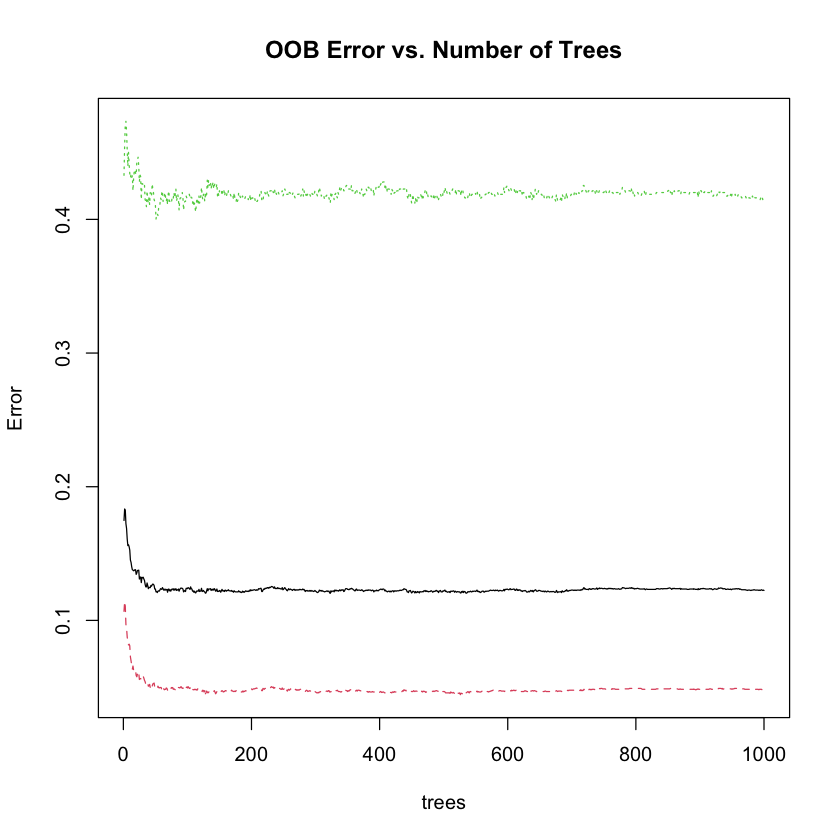

In [135]:
set.seed(123)

mtry_classification <- floor(sqrt(ncol(train_data) - 1))

# Random forest
rf_model <- randomForest(
  rain ~ ., 
  data = train_data, 
  ntree = 1000,
  mtry = mtry_classification,
  importance = TRUE
)

# Plot OOB errors
par(bg = "white")
plot(rf_model, main = "OOB Error vs. Number of Trees")

In [136]:
oob_errors <- rf_model$err.rate[, "OOB"]
optimal_trees <- which.min(oob_errors)
cat("Optimal number of trees:", optimal_trees, "\n")

Optimal number of trees: 323 


In [137]:
# Model with optimal number of trees
rf_model_optimal <- randomForest(
  rain ~ ., 
  data = train_data, 
  ntree = optimal_trees,
  mtry = mtry_classification,
  importance = TRUE
)

print(rf_model_optimal)


Call:
 randomForest(formula = rain ~ ., data = train_data, ntree = optimal_trees,      mtry = mtry_classification, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 323
No. of variables tried at each split: 17

        OOB estimate of  error rate: 11.95%
Confusion matrix:
     0   1 class.error
0 2858 135  0.04510525
1  313 444  0.41347424


***Nota:*** Hemos visto en la teoría que además del número de árboles, el otro parámetro a ajustar en los random forests es el número de predictores que se consideran en cada nodo para el splitting. En este ejemplo utlizaremos los valores típicos; n−−√ en problemas de clasificación y n/3 en problemas de predicción (siendo n el número total de predictores disponibles).

Utiliza el bosque de tamaño óptimo parar predecir la ocurrencia en el test, y conserva la predicción.

Seguidamente, tal y como hicimos con los árboles individuales, vamos a crear dos random forests para la cantidad, uno que se entrene sobre todo el dataset de train y otro que se entrene sólo sobre los días de lluvia (en el train). De nuevo, tendrás que estimar cuál es el número óptimo de árboles en cada uno de ellos (prueba bosques de hasta 1000 árboles). ¿Qué tamaños óptimos obtienes?

In [139]:
predictions_occurrence_rf <- predict(rf_model_optimal, newdata = test_data[, -1])

# <font color="pink"> Regression

### <font color="pink"> Full Forest, all data

In [106]:
set.seed(123)

mtry_regression <- floor(ncol(train_regression) / 3)

# Random forest
rf_full <- randomForest(
  rain_amount ~ .,
  data = train_regression,
  ntree = 1000,
  mtry = mtry_regression,
  importance = TRUE
)

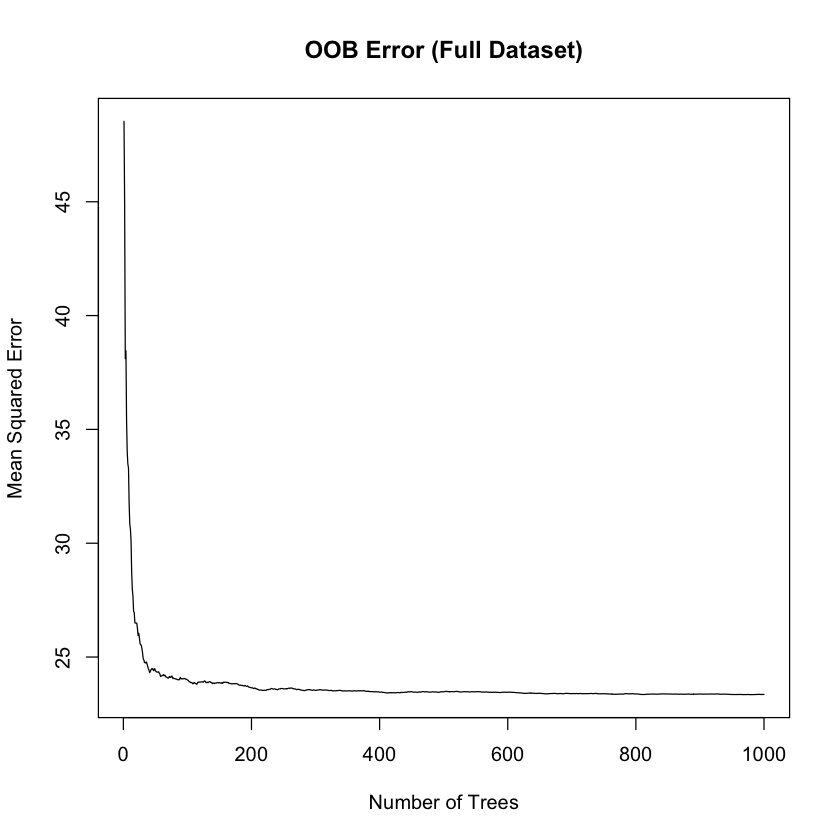

In [107]:
# Plot OOB errors
par(bg = "white")
plot(rf_full$mse, type = "l", xlab = "Number of Trees", ylab = "Mean Squared Error",
     main = "OOB Error (Full Dataset)")

In [121]:
threshold <- 0.01
oob_differences <- abs(diff(rf_full$mse))
optimal_trees_full <- which(oob_differences < threshold)[1]

if (!is.na(optimal_trees_full)) {
  cat("Optimal number of trees (with threshold):", optimal_trees_full, "\n")
} else {
  cat("No optimal value found within threshold, defaulting to maximum trees:", 1000, "\n")
}

Optimal number of trees (with threshold): 18 


### <font color="pink"> Full Forest, rain data

In [109]:
rainy_train <- train_regression[train_regression$rain_amount >= 1, ]

# Random forest
set.seed(123)
rf_rainy <- randomForest(
  rain_amount ~ .,
  data = rainy_train,
  ntree = 1000,
  mtry = mtry_regression,
  importance = TRUE
)

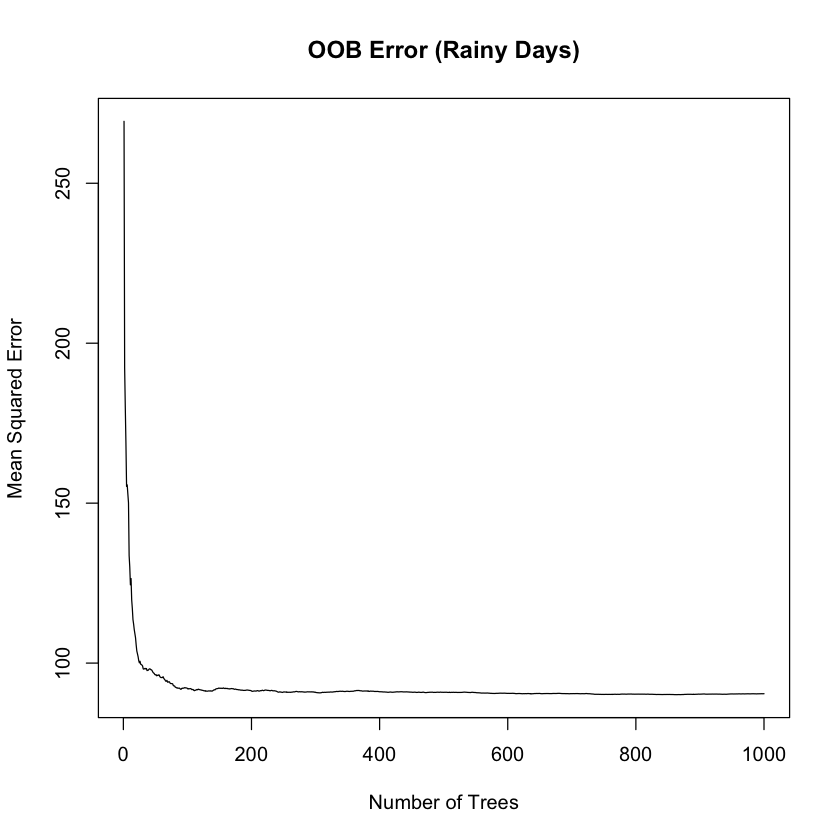

In [110]:
# Plot OOB errors
par(bg = "white")
plot(rf_rainy$mse, type = "l", xlab = "Number of Trees", ylab = "Mean Squared Error",
     main = "OOB Error (Rainy Days)")

In [122]:
threshold <- 0.01
oob_differences <- abs(diff(rf_rainy$mse))
optimal_trees_rainy <- which(oob_differences < threshold)[1]

if (!is.na(optimal_trees_rainy)) {
  cat("Optimal number of trees (with threshold):", optimal_trees_rainy, "\n")
} else {
  cat("No optimal value found within threshold, defaulting to maximum trees:", 1000, "\n")
}

Optimal number of trees (with threshold): 75 


The optimal number of trees for the random forest trained on the full dataset is 18, while for the random forest trained on rainy days only, it is 75. These optimal values were determined using a threshold of 0.01 for the difference in mean squared error, which provides a good balance between precision and computational cost.

Utiliza los bosques óptimos encontrados para predecir la cantidad en el test, y conserva las predicciones obtenidas.

Construye las predicciones completas (ocurrencia×cantidad) de test y valídalas en función de las mismas métricas utilizadas en el apartado anterior.

Pregunta: Compara estos resultados con los obtenidos para árboles individuales. ¿Qué conclusiones obtienes de la comparación entre árboles individuales y random forests?

### <font color="pink"> Filtered Forest, all data

In [124]:
rf_full_optimal <- randomForest(
  rain_amount ~ ., 
  data = train_regression, 
  ntree = optimal_trees_full,
  mtry = mtry_regression,
  importance = TRUE
)

### <font color="pink"> Filtered Forest, rain data

In [125]:
rf_rainy_optimal <- randomForest(
  rain_amount ~ ., 
  data = rainy_train, 
  ntree = optimal_trees_rainy,
  mtry = mtry_regression,
  importance = TRUE
)

# <font color="pink"> Predictions

In [156]:
# Prediction with Full Random Forest
predictions_full_rf <- predict(rf_full_optimal, newdata = test_regression)

In [157]:
# Prediction with Rainy Days Random Forest
# Subset the test dataset for rainy days (rain_amount >= 1)
rainy_test <- test_regression[test_regression$rain_amount >= 1, ]
# Predictions using the Random Forest Rainy Days Model
predictions_rainy_rf <- predict(rf_rainy_optimal, newdata = rainy_test)
# Combine predictions for rainy days with 0 for non-rainy days
predictions_combined_rf <- ifelse(test_regression$rain_amount >= 1, predictions_rainy_rf, 0)

In [158]:
# Complete series
predictions_occurrence_rf <- as.numeric(as.character(predictions_occurrence_rf))

final_predictions_full <- predictions_occurrence_rf * predictions_full_rf
final_predictions_combined <- predictions_occurrence_rf * predictions_combined_rf

# <font color="pink"> Results validation

In [142]:
conf_matrix_rf <- confusionMatrix(factor(predictions_occurrence_rf), factor(test_data$rain))

# print(conf_matrix_rf)

Accuracy: 0.8584 


In [143]:
# RMSE
rmse_full_rf <- sqrt(mean((test_regression$rain_amount - final_predictions_full)^2))
rmse_combined_rf <- sqrt(mean((test_regression$rain_amount - final_predictions_combined)^2))

# Spearman Correlation
spearman_full_rf <- cor(test_regression$rain_amount, final_predictions_full, method = "spearman")
spearman_combined_rf <- cor(test_regression$rain_amount, final_predictions_combined, method = "spearman")

# Variance Ratio
variance_ratio_full_rf <- var(final_predictions_full) / var(test_regression$rain_amount)
variance_ratio_combined_rf <- var(final_predictions_combined) / var(test_regression$rain_amount)

In [159]:
cat("Random Forest - Binary Model:\n")
cat("Accuracy:", conf_matrix_rf$overall["Accuracy"], "\n\n")

cat("Random Forest - Full Model:\n")
cat("RMSE:", rmse_full_rf, "\n")
cat("Spearman Correlation:", spearman_full_rf, "\n")
cat("Variance Ratio:", variance_ratio_full_rf, "\n\n")

cat("Random Forest - Rainy Days Model:\n")
cat("RMSE:", rmse_combined_rf, "\n")
cat("Spearman Correlation:", spearman_combined_rf, "\n")
cat("Variance Ratio:", variance_ratio_combined_rf, "\n")

Random Forest - Binary Model:
Accuracy: 0.8584 

Random Forest - Full Model:
RMSE: 4.467112 
Spearman Correlation: 0.5485688 
Variance Ratio: 0.4040711 

Random Forest - Rainy Days Model:
RMSE: 4.49608 
Spearman Correlation: 0.5933918 
Variance Ratio: 0.3224582 


| Metric                | Full Random Forest  | Rainy Days Random Forest | Binary Random Forest |
|-----------------------|---------------------|---------------------------| -------------------- |
| RMSE                 | 4.467              | 4.496                    |                      |
| Spearman Correlation | 0.549              | 0.593                    |                      |
| Variance Ratio       | 0.404              | 0.322                    |                      |
| Accuracy (%)         |                    |                          | 85.84                |


For the binary rain/no rain classification, the Random Forest model achieves an accuracy of 85.84%, slightly outperforming the individual tree model and demonstrating strong performance in detecting rainfall occurrence.

For predicting rainfall amounts, the Full Model shows a slightly lower RMSE (4.467 vs. 4.496) and a better Variance Ratio (0.404 vs. 0.322), indicating superior generalization and stability across the entire dataset. However, the Rainy Days Model achieves a higher Spearman correlation (0.593 vs. 0.549), suggesting it better captures monotonic trends in rainy days.

Again, depending on the objective, the Full Model is more suitable for general applications like climate monitoring or global forecasting, while the Rainy Days Model is preferable for analyzing rainfall patterns and extreme events.

# <font color="pink"> Comparison between Individual Tree Model and Random Forest Model </font>

| Metric       | Individual Tree | Random Forest |
|--------------|-----------------|---------------|
| Accuracy (%) | 84.48           | 85.84         |

The Random Forest Binary Model achieves an accuracy of 85.84%, outperforming the individual tree model (84.48%) and demonstrating stronger generalization for rain/no rain classification.

| Metric                | Individual Tree - Full Model | Random Forest - Full Model |
|-----------------------|-----------------|---------------|
| RMSE                 | 4.520           | 4.467         |
| Spearman Correlation | 0.542           | 0.549         |
| Variance Ratio        | 0.408           | 0.404         |

For predicting rainfall amounts, the Full Random Forest Model performs better overall, with a lower RMSE (4.467 vs. 4.520) and a slightly higher Spearman correlation (0.549 vs. 0.542), indicating improved precision and monotonic relationship capture. However, the Variance Ratio is comparable between the two models.
 

| Metric                | Individual Tree - Rainy Days Model | Random Forest - Rainy Days Model |
|-----------------------|-----------------|---------------|
| RMSE                 | 4.504           | 4.496         |
| Spearman Correlation | 0.601           | 0.593         |
| Variance Ratio        | 0.348           | 0.322         |

In the Rainy Days Model, individual trees show a slight advantage in Spearman correlation (0.601 vs. 0.593) and Variance Ratio (0.348 vs. 0.322), suggesting a marginally better ability to capture monotonic trends and variability in rainy days. Nonetheless, the Random Forest Rainy Days Model achieves a similar RMSE (4.496 vs. 4.504), demonstrating robustness.

**Overall, Random Forests provide superior generalization and robustness, especially for binary classification and full dataset predictions, while individual trees may slightly excel in specialized cases like rainfall predictions on rainy days.**

# <font color="red"> -----------------------------------------------------------------------------

## Modelos lineales generalizados (GLMs) (1.5 puntos)

Usaremos a continuación GLMs para el mismo problema abordado en los apartados anteriores. Como ya hemos visto en otras sesiones, debemos utilizar la familia binomial con función de enlace logit (regresión logística) para clasificación y la familia Gamma con función de enlace logarítmica para la cantidad.

Comenzamos con el modelo para la ocurrencia.

Una vez tenemos el modelo, lo utilizamos para predecir en el test. Tendremos que convertir la predicción probabilística obtenida en binaria (considera un umbral 0.5).

A continuación, ajustamos el modelo de cantidad. Para ello tenemos que seleccionar previamente los días de lluvia (la familia Gamma sólo acepta valores positivos).

Utilizamos el modelo obtenido para predecir la cantidad en el test.

De nuevo, multiplicamos la ocurrencia por la cantidad para obtener la predicción completa en el test y la validamos en función de las métricas de validación que utilizamos para CART y random forests.

Pregunta: Compara estos resultados con los obtenidos para CART y random forests. ¿Qué conclusiones obtienes?

# <font color="pink"> Binomial

In [161]:
# Model for Occurrence (Binomial Logistic Regression)
glm_occurrence <- glm(rain ~ .,
    family = binomial(link = "logit"),
    data = train_data
    )

In [163]:
predictions_occurrence_prob <- predict(glm_occurrence, newdata = test_data, type = "response")

# Convert probabilities to binary predictions
predictions_occurrence_glm <- ifelse(predictions_occurrence_prob > 0.5, 1, 0)

In [164]:
# Calculate accuracy
conf_matrix_glm <- confusionMatrix(
  factor(predictions_occurrence_glm), 
  factor(test_data$rain)
)
accuracy_glm <- conf_matrix_glm$overall["Accuracy"]
cat("Accuracy (GLM Binary Model):", accuracy_glm, "\n")

Accuracy (GLM Binary Model): 0.868 


# <font color="pink"> Gamma

In [238]:
# Model for Quantity (Gamma Regression) without reductions
rainy_train_nored <- train_regression[train_regression$rain_amount >= 1, ]  # Filter rainy days

glm_quantity_nored <- glm(
  rain_amount ~ .,
  family = Gamma(link = "log"),
  data = rainy_train_nored
)

Warning message:
"glm.fit: algorithm did not converge"


In [246]:
# Predict quantities on rainy days in the test set (no reduction)
rainy_test_nored <- test_regression[test_regression$rain_amount >= 1, ]
predictions_quantity_glm_nored <- predict(
  glm_quantity_nored,
  newdata = rainy_test_nored,
  type = "response"
)

# Combine occurrence and quantity predictions for complete predictions (no reduction)
predictions_combined_glm_nored <- ifelse(
  predictions_occurrence_glm == 1,
  predictions_quantity_glm_nored,
  0
)

final_predictions_glm_nored <- predictions_occurrence_glm * predictions_combined_glm_nored

The initial GLM model failed to converge due to the high number of predictors. To address this issue, I constructed a new model by reducing the predictors, selecting one out of every 4 predictors (by = 4). This minimal reduction ensures the model’s convergence while retaining sufficient predictive information.

In [251]:
# Construct a new model that converges
# Model for Quantity (Gamma Regression) with reductions
selected_predictors <- seq(1, ncol(rainy_train_nored) - 1, by = 4)
reduced_rainy_train <- rainy_train_nored[, c(1, selected_predictors + 1)]

glm_quantity <- glm(
  rain_amount ~ .,
  family = Gamma(link = "log"),
  data = reduced_rainy_train
)

In [247]:
# Predict quantities on rainy days in the test set (with reduction)
rainy_test <- test_regression[test_regression$rain_amount >= 1, ]
rainy_test <- rainy_test[, names(reduced_rainy_train)]  # Ensure consistency with training predictors
predictions_quantity_glm <- predict(
  glm_quantity,
  newdata = rainy_test,
  type = "response"
)

# Combine occurrence and quantity predictions for complete predictions (with reduction)
predictions_combined_glm <- ifelse(
  predictions_occurrence_glm == 1,
  predictions_quantity_glm,
  0
)

final_predictions_glm <- predictions_occurrence_glm * predictions_combined_glm

# <font color="pink"> Results validation

In [248]:
# Metrics for GLM without reduction
rmse_glm_nored <- sqrt(mean((test_regression$rain_amount - final_predictions_glm_nored)^2))
spearman_glm_nored <- cor(test_regression$rain_amount, final_predictions_glm_nored, method = "spearman")
variance_ratio_glm_nored <- var(final_predictions_glm_nored) / var(test_regression$rain_amount)

In [249]:
# Metrics for GLM with reduction
rmse_glm <- sqrt(mean((test_regression$rain_amount - final_predictions_glm)^2))
spearman_glm <- cor(test_regression$rain_amount, final_predictions_glm, method = "spearman")
variance_ratio_glm <- var(final_predictions_glm) / var(test_regression$rain_amount)

In [250]:
# Print metrics for GLM without reduction
cat("GLM Model (No Reduction):\n")
cat("RMSE:", rmse_glm_nored, "\n")
cat("Spearman Correlation:", spearman_glm_nored, "\n")
cat("Variance Ratio:", variance_ratio_glm_nored, "\n\n")

# Print metrics for GLM with reduction
cat("GLM Model (With Reduction):\n")
cat("RMSE:", rmse_glm, "\n")
cat("Spearman Correlation:", spearman_glm, "\n")
cat("Variance Ratio:", variance_ratio_glm, "\n")

GLM Model (No Reduction):
RMSE: 6.192955 
Spearman Correlation: 0.5874135 
Variance Ratio: 1.237031 

GLM Model (With Reduction):
RMSE: 4.988195 
Spearman Correlation: 0.5875898 
Variance Ratio: 0.5523071 


The GLM model with predictor reduction demonstrates superior performance compared to the model without reduction. The reduced model achieves a significantly lower RMSE (4.99 vs. 6.19) and a variance ratio closer to 1 (0.55 vs. 1.24), indicating better precision and a more balanced representation of variability. Both models maintain similar Spearman correlations (~0.587), showing that predictor reduction does not compromise the model’s ability to capture monotonic trends. Given these results, the reduced model is preferable due to its higher accuracy and better generalization.

# <font color="pink"> Comparison among Individual Tree, Random Forest and GLM

| Metric       | Individual Tree | Random Forest |  GLM  |
|--------------|-----------------|---------------| ----- |
| Accuracy (%) | 84.48           | 85.84         | 86.80 |

The GLM model achieves the highest accuracy (86.80%), outperforming both Random Forests (85.84%) and Individual Trees (84.48%). This suggests that the logistic regression approach in GLM is slightly more effective in distinguishing between rain and no rain days.

| Metric                | Individual Tree - Full Model | Random Forest - Full Model |
|-----------------------|------------------------------|----------------------------|
| RMSE                  | 4.520                        | 4.467                      |
| Spearman Correlation  | 0.542                        | 0.549                      |
| Variance Ratio        | 0.408                        | 0.404                      |

Here the previous results.

| Metric                | Individual Tree - Rainy Days Model | Random Forest - Rainy Days Model |  GLM  |
|-----------------------|------------------------------------|----------------------------------| ----- |
| RMSE                  | 4.504                              | 4.496                            | 4.988 |
| Spearman Correlation  | 0.601                              | 0.593                            | 0.588 |
| Variance Ratio        | 0.348                              | 0.322                            | 0.552 |

For rainy days, Random Forests demonstrate the best performance with the lowest RMSE (4.496) and a well-balanced Variance Ratio (0.322). The GLM model, with reduced predictors, shows a slightly higher RMSE (4.988) but maintains good balance with a Variance Ratio of 0.552. Individual Trees also perform competitively, with a slightly higher RMSE (4.504) but the highest Spearman Correlation (0.601), reflecting their superior ability to capture monotonic trends in rainfall data.

Overall, Random Forests are the most robust and precise choice for predicting rainfall amounts on rainy days, thanks to their ability to generalize well and handle complex non-linear relationships. GLM models excel in binary classification tasks (achieving the highest accuracy) and provide balanced predictions for rainfall amounts, though their RMSE is higher compared to Random Forests. Individual Trees, while simpler, offer good interpretability and effectively capture trends, making them suitable for scenarios where computational efficiency or clarity is a priority.

GLMs perform well when the data follows a linear or log-linear structure. However, they struggle with non-linear relationships and require careful handling of predictors to avoid issues like collinearity and overdispersion. Random Forests strike the best balance between accuracy and generalization, excelling at capturing complex patterns in datasets with high variability. CART models provide excellent interpretability and are effective for identifying basic relationships, but they are more prone to overfitting than Random Forests, limiting their generalization in more complex scenarios.

## k nearest neighbors (k-NN) (1.5 puntos)

La última de las técnicas a utilizar será vecinos cercanos (ten en cuenta que en este caso ya no tendremos que predecir por separado ocurrencia y cantidad). Comenzaremos por una versión de k-NN en la que sólo se considere el vecino más cercano (utiliza la función knn.reg del paquete FNN).

Nota: Recuerda que en la técnica k-NN es muy importante pre-procesar adecuadamente (estandarizar) los predictores.

Como vimos en su día, el único parámetro a ajustar en la técnica k-NN es k (número de vecinos). Utilizaremos el paquete caret para encontrar el k óptimo en nuestro problema. Para ello, considera una cross-validación con 10 folds sobre el dataset de train y barre todos los k impares desde 1 a 50.

Utiliza este k óptimo para predecir en el test.

Valida las dos predicciones (con k=1 y con k=óptimo) en el test, en función de las medidas que se han ido utilizando en los apartados anteriores.

Pregunta: ¿Qué diferencias obtienes entre las dos versiones utilizadas de la técnica k-NN? ¿A qué se deben?

In [ ]:
## Incluir el codigo y responder a la cuestion

## Conclusiones generales (2 puntos)

A la vista de los resultados obtenidos, argumenta razonadamente qué técnica o técnicas serían las mejores para la predicción de lluvia en Lisboa. Justifica tu respuesta.

In [ ]:
## occurrence prediction for test

A continuación, ajustamos el modelo de cantidad. Para ello tenemos que seleccionar previamente los días de lluvia (la familia Gamma sólo acepta valores positivos). 

In [ ]:
## GLM for amount

Utilizamos el modelo obtenido para predecir la cantidad en el test.

In [ ]:
## amount prediction for test

De nuevo, multiplicamos la ocurrencia por la cantidad para obtener la predicción completa en el test y la validamos en función de las métricas de validación que utilizamos para CART y random forests.

In [ ]:
# final prediction for test

# validation

**Pregunta:** Compara estos resultados con los obtenidos para CART y random forests. ¿Qué conclusiones obtienes?